In [3]:
import math
import pickle
import numpy as np

## 工作路径

In [4]:
ROBUST_BASE = '/home/LAB/wangd/graduation_project/ranked list truncation/dataset/robust04'
MQ_BASE = '/home/LAB/wangd/graduation_project/ranked list truncation/dataset/mq2007'

## 评估函数 

In [3]:
def cal_F1(ranked_list: list, k: int) -> float:
    """
    计算F1 score
    k: 截断到第k个，从1计数
    """
    count, N_D = sum(ranked_list[:k]), sum(ranked_list)
    p_k = count / k
    r_k = (count / N_D) if N_D != 0 else 0
    return (2 * p_k * r_k / (p_k + r_k)) if p_k + r_k != 0 else 0


def cal_DCG(ranked_list: list, k: int, penalty=-1) -> float:
    """
    计算DCG
    """
    value = 0
    for i in range(k): 
        value += (1 / math.log(i + 2, 2)) if ranked_list[i] else (penalty / math.log(i + 2, 2))
    return value

## Greedy-k处理流程

In [4]:
def dataset_prepare(dataset_name: str, DATASET_BASE) -> list:
    # 这里不需要train
    with open('{}/{}_train.pkl'.format(DATASET_BASE, dataset_name), 'rb') as f:
        train_data = pickle.load(f)
    with open('{}/{}_test.pkl'.format(DATASET_BASE, dataset_name), 'rb') as f:
        test_data = pickle.load(f)
    train_rl, test_rl = {}, {}
    for key in train_data: 
        train_rl[key] = list(map(lambda x: 1 if x in gt[key] else 0, train_data[key].keys()))
    for key in test_data:
        test_rl[key] = list(map(lambda x: 1 if x in gt[key] else 0, test_data[key].keys()))
    return train_rl, test_rl


def greedy_scores(dataset_name: str, DATASET_BASE) -> float:
    train_set, test_set = dataset_prepare(dataset_name, DATASET_BASE)
    F1_k, DCG_k = [], []
    if DATASET_BASE == ROBUST_BASE: len_rt = 300
    else: len_rt = 40
    for key in train_set:
        per_k_F1, per_k_DCG = [0], [0]
        for i in range(1, len_rt + 1):
            per_k_F1.append(cal_F1(train_set[key], i))
            per_k_DCG.append(cal_DCG(train_set[key], i))
        F1_k.append(per_k_F1)
        DCG_k.append(per_k_DCG)
    
    F1_k_mean, DCG_k_mean = np.mean(np.array(F1_k), axis=0), np.mean(np.array(DCG_k), axis=0)
    F1_greedy, DCG_greedy = np.argmax(F1_k_mean), np.argmax(DCG_k_mean)

    test_F1 = [cal_F1(test_set[key], F1_greedy) for key in test_set]
    test_DCG = [cal_DCG(test_set[key], DCG_greedy) for key in test_set]
    return sum(test_F1) / len(test_F1), sum(test_DCG) / len(test_DCG)

# Robust04

In [5]:
# 导入ground truth
with open('{}/gt.pkl'.format(ROBUST_BASE), 'rb') as f:
    gt = pickle.load(f)
    for key in gt: gt[key] = set(gt[key])
len(gt['301'])

448

## Greedy-k结果

In [6]:
print('BM25 Greedy-k: {}'.format(greedy_scores('bm25', ROBUST_BASE)))
print('DRMM Greedy-k: {}'.format(greedy_scores('drmm', ROBUST_BASE)))
print('DRMM_TKS Greedy-k: {}'.format(greedy_scores('drmm_tks', ROBUST_BASE)))

BM25 Greedy-k: (0.3039401630633967, 0.2)
DRMM Greedy-k: (0.29970861058662285, 0.4061859507142915)
DRMM_TKS Greedy-k: (0.6263449758542731, 7.277687488608172)


# MQ2007

In [7]:
# 导入ground truth
with open('{}/gt.pkl'.format(MQ_BASE), 'rb') as f:
    gt = pickle.load(f)
    for key in gt: gt[key] = set(gt[key])
len(gt['10'])

16

In [8]:
print('BM25 Greedy-k: {}'.format(greedy_scores('bm25', MQ_BASE)))
print('DRMM_TKS Greedy-k: {}'.format(greedy_scores('drmm_tks', MQ_BASE)))

BM25 Greedy-k: (0.44646734451249115, 0.0)
DRMM_TKS Greedy-k: (0.5929847007510834, 1.4959283707722182)


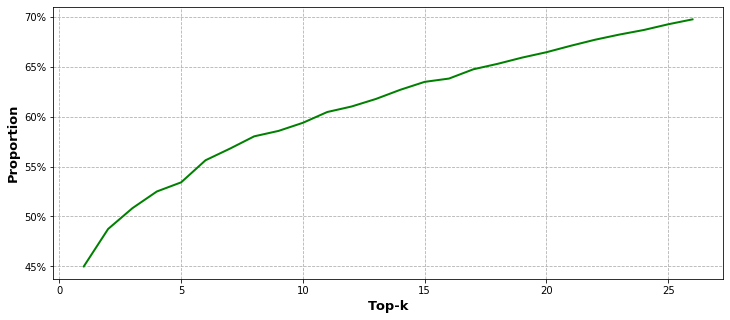